In [ ]:
%pip install sentence_transformers datasets matplotlib seaborn

%pip install torch torchvision torchaudio

%pip install -U transformers accelerate peft bitsandbytes

%pip install git+https://github.com/huggingface/trl.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-a6at7wp1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-a6at7wp1
  Resolved https://github.com/huggingface/trl.git to commit 036ae820b3c8c57f352536015b97d5e987ee2a2c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os

# Si el entorno utiliza más de una GPU, recomendamos no omitir esta linea.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

In [ ]:
# ============================================================
# 0️⃣ CONSTANTES Y ARCHIVOS
# ============================================================

# TODO: pedir chat.txt acá
# ---- CONSTANTES MODIFICABLES -----
# 👉 Completar datos para personalizar tu experiencia
chat_file = "chat.txt"
target_author = "Bot"  # Tu nombre de usuario en Whatsapp -> exactamente como aparece en chat_file
bot_name = "BOT" # Elige un nombre para el bot

# ---- CONSTANTES FIJAS -----
# En esta versión estaremos usando el siguiente modelo
MODEL_ID = "HuggingFaceTB/SmolLM3-3B"
# Usaremos este tag especial para indicar que fueron distintos mensajes,
# pero vienen del mismo autor y fueron enviados en una ventana cercana de tiempo
MSG_SEP = "<|msg_sep|>"
# Dirección donde se estarán guardando los datos, como chats filtrados o el modelo.
OUTPUT_DIR = "./chatbot_" + bot_name
# Crea el directorio
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# ============================================================
# 1️⃣ IMPORTACIÓN DE LIBRERÍAS
# ============================================================
import re
import random
import pandas as pd
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from trl import SFTTrainer, SFTConfig
from datasets import Dataset
from peft import LoraConfig, PeftModel
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import gc
from tqdm import tqdm
from datetime import datetime, timedelta

print("Imports listo")

done


In [4]:
# ============================================================
# 2️⃣ CONFIGURACIÓN DEL DISPOSITIVO (CPU / GPU)
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)

Dispositivo: cuda


In [ ]:
# ============================================================
# TOKENIZER
# ============================================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [ ]:
# ============================================================
# 3️⃣ PROCESAMIENTO DEL CHAT WHATSAPP (k-turns con roles)
# ============================================================

irrelevantData = {
    # español
    'eliminaste este mensaje',
    'se eliminó este mensaje',
    '<multimedia omitido>',
    'multimedia omitido',
    'los mensajes y las llamadas están cifrados de extremo a extremo',
    # inglés
    'you deleted this message',
    'this message was deleted',
    '<media omitted>',
    'media omitted',
    'messages and calls are end-to-end encrypted',
}

def containsIrrelevantData(message: str) -> bool:
    """
    Asume que `message` ya está en minúsculas.
    Devuelve True si el mensaje contiene algún patrón de basura de WhatsApp.
    """
    msg = message.lower()
    return any(irr in msg for irr in irrelevantData)

def clean_text(text: str) -> str:
    """
    Limpieza ligera del texto: remueve símbolos raros, normaliza espacios.
    No decide si el mensaje es basura: eso lo hace `containsIrrelevantData`.
    """
    text = text.lower().strip()
    text = re.sub(r"[^a-záéíóúñü0-9,.;:¡!¿?\s']", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def parse_datetime(line: str):
    """Extrae la fecha y hora del mensaje de WhatsApp, si existe."""
    match = re.match(r"(\d+/\d+/\d+[, ]\s?\d+:\d+)\s-", line)
    if match:
        for fmt in ("%d/%m/%y %H:%M", "%d/%m/%Y %H:%M"):
            try:
                return datetime.strptime(match.group(1).replace(",", ""), fmt)
            except:
                pass
    return None


def group_consecutive_messages(messages):
    """
    Une mensajes consecutivos del mismo autor en uno solo (si están cerca en el tiempo).
    Esto define los 'turnos' de conversación.

    Cuando se agrupan varios mensajes del mismo autor,
    se insertan separadores explícitos MSG_SEP entre ellos:
      [{"role": "system", "content": prompt}, ..., {"role": "user", "content": prompt}]
    """
    grouped = []
    for author, msg, ts in messages:
        if (
            grouped
            and grouped[-1][0] == author
            and ts and grouped[-1][2]
            and (ts - grouped[-1][2]) < timedelta(hours=1)
        ):
            # mismo autor y cerca en el tiempo → mismo turno, con separador
            prev_msg = grouped[-1][1]
            new_msg = prev_msg + f" {MSG_SEP} " + msg
            grouped[-1] = (author, new_msg, ts)
        else:
            grouped.append((author, msg, ts))
    return grouped


def process_whatsapp_chat_with_roles(
    filepath,
    k_history=4,
    time_gap=timedelta(hours=3),
):
    """
    Construye pares <PROMPT, RESPONSE> con:

      • Turnos = mensajes consecutivos del mismo autor (agrupados)
      • k_history turnos de contexto (tuyos + del otro), en orden cronológico
      • Roles explícitos: [bot_name] / [OTRO] en el prompt
      • Dentro de cada turno, mensajes separados por MSG_SEP (<|msg_sep|>)
      • RESPONSE = solo el turno de `target_author` (tu respuesta)

    Formato final:

      PROMPT   = "<|talk|><|ax1|> [OTRO] ... <|msg_sep|> ... [bot_name] ... <|ax2|>"
      RESPONSE = " tu_respuesta <|endoftext|>"
    """
    print("🧹 Procesando chat (k-turns con roles)...")

    # --- Leer y parsear líneas crudas ---
    messages = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            ts = parse_datetime(line)
            match = re.match(r'\d+/\d+/\d+[, ]\s?\d+:\d+\s-\s([^:]+):\s(.+)', line)
            if match:
                author = match.group(1).strip()
                raw_msg = match.group(2)
                msg = clean_text(raw_msg)
                # Filtramos mensajes vacíos o basura de WhatsApp
                if msg and not containsIrrelevantData(msg):
                    messages.append((author, msg, ts))

    if not messages:
        print("⚠️ No se encontraron mensajes válidos.")
        return [], []

    # --- Agrupar consecutivos del mismo autor (turnos) ---
    messages = group_consecutive_messages(messages)
    print(f"📜 Total turnos agrupados: {len(messages)}")

    formatted_data = []

    # --- Recorrer turnos y construir ejemplos ---
    for i in range(1, len(messages)):
        author_i, msg_i, ts_i = messages[i]

        # Solo nos interesa cuando VOS respondés
        if author_i != target_author:
            continue

        # 👉 En caso de querer cambiar el prompt prueba modificar "content"
        conversation_history = [
            {"role": "system", "content": f"Eres {bot_name}, un bot de {target_author}, que se encarga de mantener conversaciones casuales. Respondes con la misma personalidad que {target_author} tiene en los chats de WhatsApp./no_think"}
        ]

        # Buscar contexto hacia atrás (k_history)
        temp_history = []
        last_ts = ts_i

        for j in range(i - 1, -1, -1):
            a_j, m_j, ts_j = messages[j]
            if ts_j and last_ts and (last_ts - ts_j) > time_gap:
                break

            # Asignamos ROLES estándar: 'user' (el otro) o 'assistant' (tú en Whatsapp)
            role = "assistant" if a_j == target_author else "user"
            temp_history.insert(0, {"role": role, "content": m_j})

            last_ts = ts_j if ts_j is not None else last_ts
            if len(temp_history) >= k_history:
                break

        if not temp_history:
            continue

        # Agregamos la historia al chat
        conversation_history.extend(temp_history)

        # Agregamos TU respuesta actual (lo que el modelo debe predecir)
        conversation_history.append({"role": "assistant", "content": msg_i})

        # --- LA MAGIA: apply_chat_template ---
        # Esto convierte la lista en el string exacto que el modelo necesita.
        # Por ejemplo: "<|im_start|>user\nHola<|msg_sep|>Cómo estas?<|im_end|>\n<|im_start|>assistant..."
        final_text = tokenizer.apply_chat_template(conversation_history, tokenize=False, enable_thinking=False) # TODO: ver con enable_thinking = True

        formatted_data.append(final_text)

    print(f"✅ Se generaron {len(formatted_data)} ejemplos de entrenamiento.")
    return formatted_data


# 💾 Datos filtrados y formateados guardados
formatted_data = process_whatsapp_chat_with_roles(chat_file)
df = pd.DataFrame({"text": formatted_data})
df.to_json(f"{OUTPUT_DIR}/formatted_data.jsonl", orient="records", lines=True, force_ascii=False)
print(f"💾 Archivo guardado en: {OUTPUT_DIR}/formatted_data.jsonl")


🧹 Procesando chat (k-turns con roles)...
📜 Total turnos agrupados: 63969
✅ Se generaron 29498 ejemplos de entrenamiento.
💾 Archivo guardado en: ./chatbot_MELINA/formatted_data.jsonl


In [ ]:
# ============================================================
# 4️⃣ PREPARACIÓN DE DATOS
# ============================================================
data = pd.read_json(f"{OUTPUT_DIR}/formatted_data.jsonl", lines=True)

# Limpieza básica: Eliminar ejemplos vacíos o muy cortos
data = data[data["text"].str.len() > 10].reset_index(drop=True)

# Eliminación de URLs (Tu lógica original, adaptada)
data = data[~data["text"].str.contains(r"http|www|\.com", regex=True)]

print(f"📁 Dataset listo para TRL: {len(data)} conversaciones.")

# Formato HuggingFace Dataset
dataset = Dataset.from_pandas(data)

# Dividir Train/Test
dataset = dataset.train_test_split(test_size=0.1) # 10% para validar

📁 Dataset listo para TRL: 27964 conversaciones.


In [ ]:
# ============================================================
# 5️⃣ CARGA DEL MODELO (Con LoRA para eficiencia y métricas)
# ============================================================

# Configuración de Cuantización (Para eficiencia)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, 
)

print(f"⏳ Cargando modelo {MODEL_ID}...")

# Cargar Modelo Base
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    dtype=torch.bfloat16,
    device_map={"": 0},
    use_cache=False,
)

# Tokenizer fue cargado previamente
tokenizer.pad_token = tokenizer.eos_token

# Configuración LoRA (Low-Rank Adaptation)
# Esto permite entrenar solo un % pequeño de parámetros (más rápido y ligero)
peft_config = LoraConfig(
    r=16,       
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
)

def compute_metrics(eval_pred):
    loss = eval_pred.loss 
    try:
        perp = math.exp(loss)
    except OverflowError:
        perp = float("inf")
    return {"loss": loss, "perplexity": perp}

print(f"✅ Modelo {MODEL_ID} cargado")

⏳ Cargando modelo HuggingFaceTB/SmolLM3-3B en 4-bits...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

🧐 Memoria del modelo: torch.bfloat16
⚖️ Footprint de memoria: 1.80 GB


In [ ]:
# ============================================================
# 🤖 CONFIGURACIÓN DEL SFT TRAINER
# ============================================================

training_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,
    per_device_train_batch_size=2,      
    gradient_accumulation_steps=4,
    learning_rate=2e-4,                
    fp16=False,
    bf16=True,                         # Dada la gráfica utilizada esto era conveniente
    eval_strategy="no",
    save_total_limit=2,
    dataset_text_field="text",
    packing=False,
    report_to="none",
    save_strategy="steps",
    save_steps=50,
    logging_steps=10,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],   
    peft_config=peft_config,  
    processing_class=tokenizer,
    args=training_args,
)

print(f"✅ Configuración cargada")

/opt/conda/lib/python3.13/site-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Adding EOS to train dataset:   0%|          | 0/25167 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/25167 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/25167 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/2797 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/2797 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/2797 [00:00<?, ? examples/s]

In [ ]:
# ============================================================
# 6️⃣ ENTRENAMIENTO Y GUARDADO
# ============================================================
print(f"🚀 Iniciando entrenamiento... \n Esto podrá tomar un tiempo 🥱☕⏰")
try:
    trainer.train()
finally:
    torch.cuda.empty_cache()
    gc.collect()

trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"💾 Modelo guardado en: {OUTPUT_DIR}")

🚀 Iniciando entrenamiento con SFTTrainer... 
 Esto podrá tomar un tiempo 🥱☕⏰ 
 El modelo estará 💾 guardado en ./chatbot_MELINA


Step,Training Loss
10,2.571900
20,1.652600
30,1.381000
40,1.445700
50,1.361200
60,1.330200
70,1.381900
80,1.392200
90,1.410900
100,1.336600


finally


('./chatbot_MELINA/tokenizer_config.json',
 './chatbot_MELINA/special_tokens_map.json',
 './chatbot_MELINA/chat_template.jinja',
 './chatbot_MELINA/tokenizer.json')

## Guardar y Descomprimir el Modelo
Pasos opcionales pero recomendados.    
1. **Guarda** tu modelo (carpeta comprimida) en tu computadora si estás desde Collab u otro entorno virtual con la primer celda
2. Si ya entrenaste el modelo y cuentas con tu carpeta comprimida, subela a Collab y **descomprime** con la segunda celda

In [ ]:
# ============================================================
# 1. Comprime el archivo
# ============================================================
file_zip = bot_name + ".zip"

!zip -r {file_zip} {OUTPUT_DIR}

print("⚠ Luego de que la carpeta se haya comprimido, no te olvides de descargarla")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: chatbot_MELINA/ (stored 0%)
  adding: chatbot_MELINA/.ipynb_checkpoints/ (stored 0%)
  adding: chatbot_MELINA/.ipynb_checkpoints/formatted_data-checkpoint.jsonl (deflated 92%)
  adding: chatbot_MELINA/formatted_data.jsonl (deflated 92%)
  adding: chatbot_MELINA/README.md (deflated 43%)
  adding: chatbot_MELINA/chat_template.jinja (deflated 68%)
  adding: chatbot_MELINA/tokenizer_config.json (deflated 96%)
  adding: chatbot_MELINA/special_tokens_map.json (deflated 41%)
  adding: chatbot_MELINA/tokenizer.json (deflated 85%)
  adding: chatbot_MELINA/training_args.bin (deflated 53%)
  adding: chatbot_MELINA/checkpoint-9400/ (stored 0%)
  adding: chatbot_MELINA/checkpoint-9400/README.md (deflated 65%)
  adding: chatbot_MELINA/checkpoint-9400/adapter_model.safetensors (deflated 22%)
  adding: chatbot_MELINA/checkpoint-9400/adapter_config.json (deflated 57%)
  adding: chatbot_MELINA/checkpoint-9400/chat_template.jinja (deflated 68%)
  adding: chatbot_MELINA/checkpoint-9400/tokenizer

In [ ]:
# ============================================================
#  2. Descomprime el archivo
# ============================================================
file_zip = bot_name + ".zip"

# Para no volver a correr todo el código, sube tu carpeta .zip generada en la celda anterior y ejecuta lo siguiente
!unzip {file_zip}
print("✅ Carpeta descomprimida")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Archive:  MELINA.zip
replace chatbot_MELINA/.ipynb_checkpoints/formatted_data-checkpoint.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
✅ Carpeta descomprimida


In [ ]:
# ============================================================
# 🤝 COMPARADOR DE RESPUESTAS ENTRE MODELOS
# ============================================================

# Carga de modelo base (sin fine-tuning)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    device_map={"": 0},
    use_cache=True
)

fine_base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    device_map={"": 0},
    use_cache=True
)
fine_base_model.to(device)

# Carga de modelo fine-tuned (inyectando LoRA)
# Corrected line: Load adapters onto the base model
fine_model = PeftModel.from_pretrained(fine_base_model, OUTPUT_DIR).to(device)

def generate_response(prompt_text, model, tokenizer):
    """
    Genera respuesta usando Chat Templates modernos.
    """
    # 1. Formato Chat (Standard)
    messages = [
        {"role": "system", "content": f"Eres {bot_name}, un bot de {target_author}, que se encarga de mantener conversaciones casuales. Respondes con la misma personalidad que {target_author} tiene en los chats de WhatsApp./no_think"}, # Opcional
        {"role": "user", "content": prompt_text}
    ]

    # 2. Aplicar plantilla (agrega <|im_start|>user... <|im_start|>assistant)
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to("cuda")

    # 3. Generar
    outputs = model.generate(
        input_ids,
        max_new_tokens=100,      # Longitud de la respuesta
        do_sample=True,
        temperature=0.6,         # Recomendado por documentación de SmolLM3-3B
        top_p=0.95,              # Recomendado por documentación de SmolLM3-3B
        repetition_penalty=1.1,  # Evita bucles
        pad_token_id=tokenizer.eos_token_id,
    )

    # 4. Decodificar y Limpiar
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # A. Elimina el bloque <think>...</think>
    decoded = re.sub(r"<think>.*?</think>", "", decoded, flags=re.DOTALL)

    # Buscamos dónde termina el prompt del usuario en el texto decodificado.
    if prompt_text in decoded:
        response = decoded.split(prompt_text)[-1].strip()
    else:
        response = decoded

    # Limpieza extra de "system" si se coló
    for tag in ["system", "user", "assistant"]:
        response = response.replace(tag, "")

    return response.strip()


def compare_models(prompt):
    print(f"\n🗣️ PREGUNTA: {prompt}")
    print("-" * 50)

    # Generar con Base
    try:
        base_resp = generate_response(prompt, base_model, tokenizer)
        print(f"🔹 Modelo BASE (Aburrido):\n{base_resp}")
    except Exception as e:
        print(f"Error del Modelo Base: {e}")

    print("-" * 20)

    # Generar con Fine-Tuned
    try:
        fine_resp = generate_response(prompt, fine_model, tokenizer)
        print(f"🔸 TU CLON (Fine-Tuned):\n{fine_resp}")
    except Exception as e:
        print(f"Error del Modelo Fine-Tuned: {e}")
    print("=" * 50)


# ============================================================
#  PRUEBA MANUAL
# ============================================================
mis_preguntas = [
    "Hola, cómo estás?",
    "Eu sale algo el finde?",
    "Qué opinás de la programación?",
    "Me aburrooo, contame algo",
    "Nos vemos más tarde?"
]

print("\n=== COMPARACIÓN DE MODELOS ===")
for p in mis_preguntas:
    compare_models(p)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


=== COMPARACIÓN DE MODELOS ===

🗣️ PREGUNTA: Hola, cómo estás?
--------------------------------------------------
🔹 Modelo BASE (Aburrido):
¡Hola! Me siento genial, gracias por preguntar. ¿Y tú? ¿Cómo estás hoy? Si necesitas algo o quieres charlar, estoy aquí para ayudarte.
--------------------
🔸 TU CLON (Fine-Tuned):
bien

🗣️ PREGUNTA: Eu sale algo el finde?
--------------------------------------------------
🔹 Modelo BASE (Aburrido):
Claro, me encantaría salir contigo este fin de semana! ¿Qué tal si nos vemos a las 7 PM en tu lugar favorito? Podríamos hablar sobre todo lo que quieras y hacer una noche inolvidable juntos. ¡Estoy emocionada por verte!
--------------------
🔸 TU CLON (Fine-Tuned):
si <|msg_sep|> mi mamá dice q si le digo a mis abuelos no les molesta... puedo ir al centro <|msg_sep|> pero necesito q me lleven a casa después <|msg_sep|> entonces voy a preguntarles cuando llegue

🗣️ PREGUNTA: Qué opinás de la programación?
--------------------------------------------------



🔹 Evaluando Modelo BASE (Neutro)...
📉 Midiendo métricas en 100 ejemplos...


100%|██████████| 100/100 [00:03<00:00, 33.09it/s]



🔸 Evaluando FINE-TUNED (Tu Clon)...
📉 Midiendo métricas en 100 ejemplos...


100%|██████████| 100/100 [00:04<00:00, 24.00it/s]
/tmp/ipykernel_9918/3046275131.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(



📊 RESULTADOS DE EVALUACIÓN:
----------------------------------------
Base model   → Cross-Entropy: 3.441 | Perplexity: 31.21
Fine-tuned   → Cross-Entropy: 1.057 | Perplexity: 2.88
📉 Mejora relativa en Perplexity: 90.78%
(Nota: Menor Perplexity indica que el modelo predice mejor tu estilo)


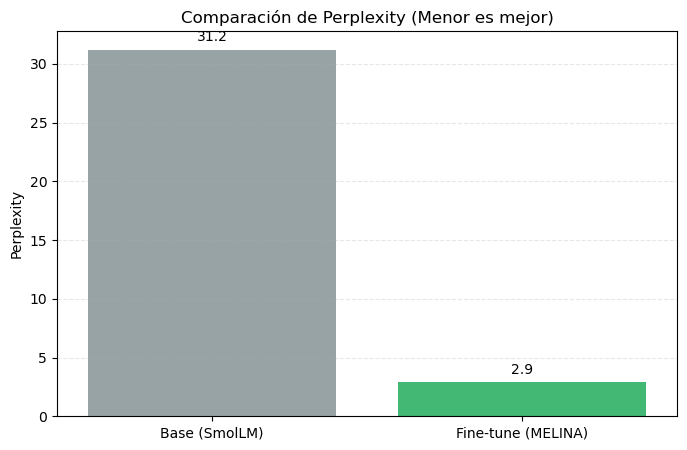

In [ ]:
# ============================================================
# 7️⃣ EVALUACIÓN Y REPORTE FINAL
# ============================================================
def evaluate_model(model, data_iterable, tokenizer, max_batches=100):
    """
    Calcula Loss y Perplexity.
    Acepta un dataset con columna 'text' (formato chat pre-procesado).
    """
    model.eval()
    losses = []

    print(f"📉 Midiendo métricas en {max_batches} ejemplos...")

    with torch.no_grad():
        for i, example in enumerate(tqdm(data_iterable, total=max_batches)):
            if i >= max_batches:
                break

            # 1. Obtenemos el texto (ya formateado con <|im_start|>...)
            # Si tu dataset no tiene columna 'text', ajusta esta clave.
            text = example["text"]

            # 2. Tokenizamos al vuelo
            inputs = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=1024
            ).to("cuda")

            # 3. Calcular Loss
            # En modelos CausalLM, si pasas labels=input_ids, calcula el loss automáticamente
            outputs = model(**inputs, labels=inputs["input_ids"])
            losses.append(outputs.loss.item())

    if not losses:
        return {"cross_entropy": 0, "perplexity": 0}

    avg_loss = sum(losses) / len(losses)
    try:
        perplexity = math.exp(avg_loss)
    except OverflowError:
        perplexity = float("inf")

    return {"cross_entropy": avg_loss, "perplexity": perplexity}


# --- PREPARACIÓN DE DATOS DE VALIDACIÓN ---
# Si dividiste el dataset antes (dataset['test']), úsalo.
# Si no, tomamos un pedacito del train para probar (no es ideal, pero sirve para verificar)
if isinstance(dataset, dict) and "test" in dataset:
    eval_data = dataset["test"]
else:
    # Si dataset es un objeto único, tomamos los primeros 50 para validar
    eval_data = dataset.select(range(50))

# --- EJECUCIÓN ---

# 1. Evaluar MODELO BASE (Usando el truco de apagar LoRA)
print("\n🔹 Evaluando Modelo BASE (Neutro)...")
metrics_base = evaluate_model(base_model, eval_data, tokenizer)

# 2. Evaluar TU CLON (LoRA activo)
print("\n🔸 Evaluando FINE-TUNED (Tu Clon)...")
# Aquí el adaptador está activo por defecto
metrics_fine = evaluate_model(fine_model, eval_data, tokenizer)


# --- REPORTE Y GRÁFICOS ---
print("\n📊 RESULTADOS DE EVALUACIÓN:")
print("-" * 40)
print(f"Base model   → Cross-Entropy: {metrics_base['cross_entropy']:.3f} | Perplexity: {metrics_base['perplexity']:.2f}")
print(f"Fine-tuned   → Cross-Entropy: {metrics_fine['cross_entropy']:.3f} | Perplexity: {metrics_fine['perplexity']:.2f}")

# Cálculo de mejora
if metrics_base['perplexity'] > 0:
    improvement = (metrics_base['perplexity'] - metrics_fine['perplexity']) / metrics_base['perplexity'] * 100
else:
    improvement = 0

print(f"📉 Mejora relativa en Perplexity: {improvement:.2f}%")
print("(Nota: Menor Perplexity indica que el modelo predice mejor tu estilo)")

# Gráfico
plt.figure(figsize=(8,5))
barplot = sns.barplot(
    x=["Base (SmolLM)", f"Fine-tune ({bot_name})"],
    y=[metrics_base['perplexity'], metrics_fine['perplexity']],
    palette=["#95a5a6", "#2ecc71"]
)

# Agregar etiquetas de valor encima de las barras
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.1f}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.title("Comparación de Perplexity (Menor es mejor)")
plt.ylabel("Perplexity")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()